In [34]:
import numpy as np
import sys
sys.path.append("../model")
from rnn_FORCE import RNN
import matplotlib.pyplot as plt
import torch
from torch import tensor
from torch import nn
import seaborn as sns
from torch.autograd.functional import jacobian
SAVEFIG = True

In [2]:
# Initializing matrix
num_nodes = 200
np.random.seed(3)  # 2

connectivity_matrix = np.ones((num_nodes, num_nodes))
weight_matrix = np.random.normal(0, 1/np.sqrt(num_nodes), (num_nodes, num_nodes))
for i in range(num_nodes):
    weight_matrix[i, i] = 0
    connectivity_matrix[i, i] = 0
output_weight_matrix = np.random.uniform(-1, 1, (1, num_nodes))
feedback_weight_matrix = np.random.uniform(-1, 1, (num_nodes, 1)) # * 0.5
init_state = np.random.uniform(-0.5, 0.5, (num_nodes, 1))
init_gain = np.ones((num_nodes, 1))
init_shift = np.zeros((num_nodes, 1))

In [3]:
# Dale's Law
excite_perc = 0.5
excite_num = int(excite_perc*num_nodes)
node_type = np.array([1]*excite_num + [-1]*(num_nodes-excite_num))
weight_type = np.tile(node_type, num_nodes).reshape(num_nodes, -1)

# Enforce Dale's Law
weight_matrix = np.abs(weight_matrix) * weight_type
output_weight_matrix = np.abs(output_weight_matrix) * node_type

# normalize
ext_weight_sum = num_nodes/4
inh_weight_sum = num_nodes/4
tmp_output_weight_matrix = output_weight_matrix.copy()
tmp_ext = tmp_output_weight_matrix[:,node_type == 1]
tmp_inh = tmp_output_weight_matrix[:,node_type == -1]
tmp_ext /= np.sum(np.abs(tmp_ext)) / ext_weight_sum
tmp_inh /= np.sum(np.abs(tmp_inh)) / inh_weight_sum
tmp_output_weight_matrix[:,node_type == 1] = tmp_ext
tmp_output_weight_matrix[:,node_type == -1] = tmp_inh
output_weight_matrix = tmp_output_weight_matrix.copy()
init_output_weight_matrix = output_weight_matrix.copy()

In [4]:
# define targets
time_points = np.arange(2000)
half_period = 20
# targets = (np.sin((time_points+1)/60*np.pi))/4 + 0.5
targets = ((np.sin((time_points + 10)/half_period*np.pi))/4 + 0.5)

# inputs with different phases and period
np.random.seed(3)
inputs = []
for i in range(num_nodes):
    this_half_period = np.random.randint(10, 30)
    this_input = (np.sin((time_points + np.random.randint(0, half_period*2))/this_half_period*np.pi))/4 + 0.5
    inputs.append(this_input)
inputs = np.array(inputs)

In [5]:
# define sigmoid
def sigmoid_np(x):
    return 1 / (1 + np.exp(-x))

def inv_sigmoid_np(x):
    return -np.log((1 / x) - 1)

Must use activation as x rather than state. Otherwise, the output would not be a linear readout and depend on u.

In [6]:
# imitate rnn_FORCE
class mysys():
    def __init__(self, weight_matrix, connectivity_matrix, gain, shift, input_weight_matrix=None, inputs=None):
        # core parameters
        self.weight_matrix = weight_matrix
        self.connectivity_matrix = connectivity_matrix
        self.gain = gain
        self.shift = shift
        self.inputs = inputs
        self.input_weight_matrix = input_weight_matrix
        self.activation_func = nn.Sigmoid()
        
        # transfer into tensor
        self.weight_matrix_tensor = tensor(self.weight_matrix)
        self.gain_tensor = tensor(self.gain)
        self.shift_tensor = tensor(self.shift)
        
        # constants
        self.time_const = 1
        self.timestep = 0.1
        self.c = self.timestep / self.time_const
        self.g = 1.5
        self.i = 0

    def f_tensor(self, x_tensor, u_tensor, r_tensor):
        # this_input_tensor = torch.matmul(tensor(self.input_weight_matrix), tensor([[self.inputs[self.i]]]))
        y_tensor = (1 - self.c) * x_tensor \
            + self.c * self.activation_func((self.gain_tensor + u_tensor) * (self.g * torch.matmul(self.weight_matrix_tensor, x_tensor) + r_tensor - self.shift_tensor))
        return y_tensor
     
    def f(self, x, u, r):
        x_tensor = tensor(x)
        u_tensor = tensor(u)
        r_tensor = tensor(r)
        y_tensor = self.f_tensor(x_tensor, u_tensor, r_tensor)
        y = y_tensor.numpy()
        return y
    
    def jacob(self, x, u, r):
        x_tensor = tensor(x)
        u_tensor = tensor(u)
        r_tensor = tensor(r)
        dydx, dydu, dydr = jacobian(self.f_tensor,(x_tensor, u_tensor, r_tensor))
        Jx_tensor = dydx.squeeze(dim=(1,3))
        Ju_tensor = dydu.squeeze(dim=(1,3))
        Jr_tensor = dydr.squeeze(dim=(1,3))
        Jx = Jx_tensor.numpy()
        Ju = Ju_tensor.numpy()
        Jr = Jr_tensor.numpy()
        return Jx, Ju, Jr

# jnn_ff = mysys(weight_matrix, connectivity_matrix, init_gain, init_shift, input_weight_matrix=feedback_weight_matrix, inputs=targets)
# jnn = mysys(weight_matrix, connectivity_matrix, init_gain, init_shift, input_weight_matrix=feedback_weight_matrix, inputs=targets)
jnn_ff = mysys(weight_matrix, connectivity_matrix, init_gain, init_shift)
jnn = mysys(weight_matrix, connectivity_matrix, init_gain, init_shift)

### Simulate Without Control

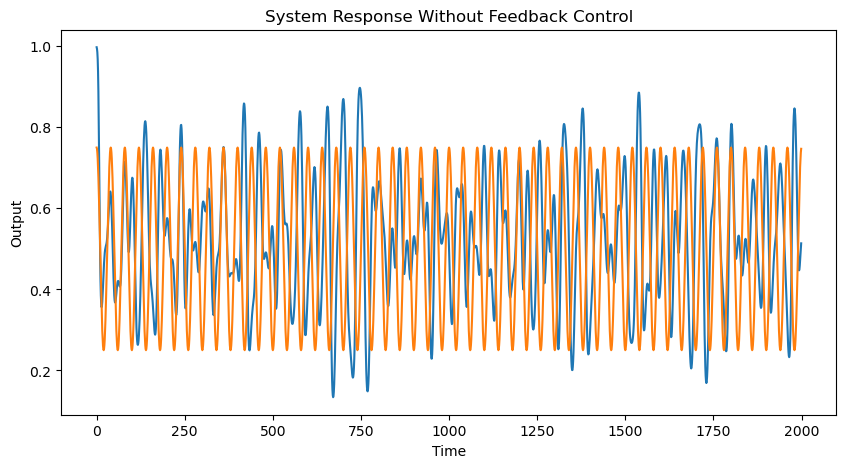

In [7]:
# Simulation Without Control
x = sigmoid_np(init_gain * init_state.copy() - init_shift)
u = init_state.copy() * 0
xs_ff_init, outputs_ff_init = [x], []
gainout= 5.5 # 1.15
shiftout= -5 # -2.5
out_lr = 0.002

for i in time_points[:-1]:
    
    # jnn_ff.i = i

    # output
    output_beforesig = output_weight_matrix @ x
    output = sigmoid_np(gainout * output_beforesig - shiftout)

    # # adjust the gainout and shiftout
    # period = 2 * half_period
    # if i > period:
    #     mean_output = np.mean(outputs_ff_init[i-period:i])
    #     amplitude = np.max(outputs_ff_init[i-period:i]) - np.min(outputs_ff_init[i-period:i])
    #     if np.abs(mean_output - 0.5) > 0.01:
    #         shiftout += out_lr * np.sign(mean_output - 0.5)
    #     if np.abs(amplitude - 0.5) > 0.01:
    #         gainout -= out_lr * np.sign(amplitude - 0.5)

    # input
    this_input = inputs[:,i]
    r = feedback_weight_matrix * this_input.reshape(-1,1)

    # update x
    x1 = jnn_ff.f(x, u, r)
    x = x1.copy()
    
    # save
    xs_ff_init.append(x)
    outputs_ff_init.append(output.item())

# final readout for x_T
output_beforesig = output_weight_matrix @ x
output = sigmoid_np(gainout * output_beforesig - shiftout)
outputs_ff_init.append(output.item())

# Plot the output
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(time_points, outputs_ff_init)
plt.plot(time_points, targets)
plt.xlabel('Time')
plt.ylabel('Output')
plt.title('System Response Without Feedback Control')
plt.show()

In [8]:
gainout, shiftout

(5.5, -5)

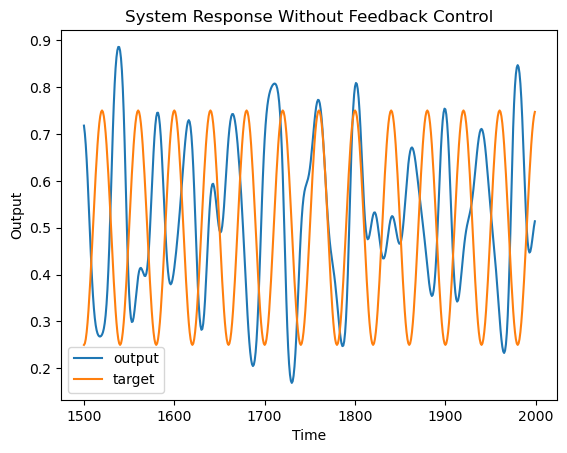

In [35]:
# Plot the output
plt.plot(time_points[-500:], outputs_ff_init[-500:], label='output')
plt.plot(time_points[-500:], targets[-500:], label='target')
plt.xlabel('Time')
plt.ylabel('Output')
plt.title('System Response Without Feedback Control')
plt.legend()
if SAVEFIG:
    plt.savefig("fig/FORCE_basis_ff_outputs_0510.png")

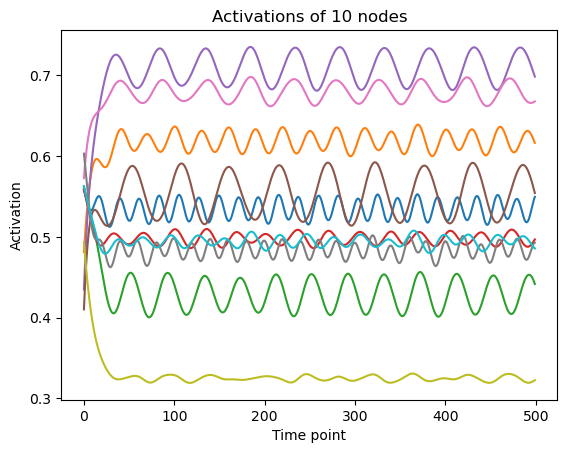

In [36]:
all_xs_ff_init = np.concatenate(xs_ff_init, axis=1)
for i in range(10, 20):
    plt.plot(all_xs_ff_init[i,0:500], label=f"Node {i}")
plt.xlabel("Time point")
plt.ylabel("Activation")
plt.title("Activations of 10 nodes")
if SAVEFIG:
    plt.savefig("fig/FORCE_basis_ff_activations_0510.png")

In [11]:
peaks = []
start = 500
end = start + 2*half_period
for i in range(num_nodes):
    y = all_xs_ff_init[i]
    p = np.argmax(y[start:end])
    peaks.append(p)
target_peak = np.argmax(targets[start:end])
relative_peaks_ff_init = np.array(peaks) - target_peak

# plus 120 for relative peaks less than 0
relative_peaks_ff_init[relative_peaks_ff_init < 0] += 2*half_period
relative_peaks_ff_init

array([13,  5, 18, 24,  9,  6, 39,  7, 27,  5, 21,  1, 12, 19, 13, 19,  3,
       19, 30, 39, 15, 24,  2, 38,  5,  4, 15, 12, 30, 10, 25,  0, 29, 22,
       17, 20, 21,  7, 20,  1,  1,  7, 25,  5, 39,  8, 11, 18, 15,  8, 17,
       13, 11, 30, 12, 19,  2, 32, 15, 38, 16,  6, 11, 30,  7, 19, 39,  5,
        6, 28, 37, 19,  2, 15, 28, 15,  4,  1, 16,  9,  6, 23, 29, 19, 19,
        5, 13, 30, 15,  0,  5, 23,  4, 32, 30, 10, 12,  1, 14, 19, 27,  3,
        7,  2, 14,  8, 15,  4, 15, 23, 16,  8, 35,  2, 22, 11, 18, 10,  4,
        6, 19, 19, 14, 19, 15, 34, 21, 18, 15, 39,  9,  6,  6,  9, 21, 12,
       11, 15, 18,  9,  1, 13,  4,  0,  1, 16, 13, 19, 12, 20,  9,  2, 29,
        8, 11, 10,  1, 19, 37, 35, 35, 22, 37, 19, 32, 20, 29, 19, 21, 12,
       16, 23, 20,  6,  4, 28, 24, 35, 25, 18, 23, 18, 35, 12, 19, 20, 19,
       22,  3, 17, 20,  1,  5, 15, 19, 12, 20,  1, 16, 33])

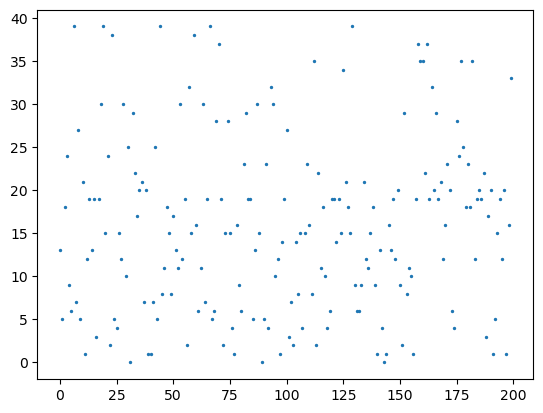

In [12]:
plt.scatter(np.arange(num_nodes), relative_peaks_ff_init, s=2)

### Discrete Tracking Control

In [13]:
# calculate the desired output before the output sigmoid
gainout= 2.5 # 1.15
shiftout= -2 # -2.5
y_tildes = (inv_sigmoid_np(targets) + shiftout) / gainout

In [14]:
# Simulate with control
x = init_state.copy()
u = init_state.copy() * 0
xs_fb, us_fb, outputs_fb_beforesig, outputs_fb = [x], [], [], []

# constants
R = np.eye(num_nodes) * 0.0001
Q1 = np.eye(num_nodes) * 0.01
Q2 = np.eye(1) * 10

for t in time_points[:-1]:

    # jnn.i = t

    # output
    output_beforesig = output_weight_matrix @ x
    output = sigmoid_np(gainout * output_beforesig - shiftout)

    # input
    this_input = inputs[:,t]
    r = feedback_weight_matrix * this_input.reshape(-1,1)
    
    # linear approxmation of nonlinear system
    # linear approximate F and G
    F, G, _ = jnn.jacob(x, u, r)   # x_t, u_t-1
    c = jnn.f(x, u, r) - F @ x - G @ u  # the constant term after approximation
    # augment the system for the constant term
    F_aug = np.concatenate([np.concatenate([F, np.eye(num_nodes)], axis=1), np.concatenate([np.zeros((num_nodes, num_nodes)), np.eye(num_nodes)], axis=1)], axis=0)
    G_aug = np.concatenate([G, np.zeros((num_nodes, num_nodes))], axis=0)
    x_aug = np.concatenate([x, c], axis=0)

    # get H
    H = output_weight_matrix.T
    L = H @ np.linalg.inv(H.T @ H)
    H_bar = (np.eye(num_nodes) - L @ H.T).T
    Q = H_bar @ Q1 @ H_bar.T + H @ Q2 @ H.T
    y_tilde = y_tildes[t+1]
    x_tilde = L @ np.array([[y_tilde]])
    x_tilde_aug = np.concatenate([x_tilde, c], axis=0)
    # Q_aug = np.concatenate([np.concatenate([Q, np.zeros((num_nodes, num_nodes))], axis=1), np.concatenate([np.zeros((num_nodes, num_nodes)), np.eye(num_nodes)], axis=1)], axis=0)
    Q_aug = np.concatenate([np.concatenate([Q, np.zeros((num_nodes, num_nodes))], axis=1), np.concatenate([np.zeros((num_nodes, num_nodes)), np.zeros((num_nodes, num_nodes))], axis=1)], axis=0)

    # get the control input u
    # backward solve
    S_t2 = Q_aug
    b_t2 = np.zeros(shape=(2 * num_nodes, 1))
    S_t1 = F_aug.T @ (S_t2 - S_t2 @ G_aug @ np.linalg.inv(G_aug.T @ S_t2 @ G_aug + R) @ G_aug.T @ S_t2) @ F_aug + Q_aug
    K_T_t1 = -np.linalg.inv(G_aug.T @ S_t2 @ G_aug + R) @ G_aug.T @ S_t2 @ F_aug
    b_t1 = (F_aug.T + K_T_t1.T @ G_aug.T) @ b_t2 - Q_aug @ x_tilde_aug
    # calculate u_t
    u1 = -np.linalg.inv(G_aug.T @ S_t1 @ G_aug + R) @ G_aug.T @ (S_t1 @ F_aug @ x_aug + b_t1)
    # u = np.linalg.pinv(G) @ (G @ u1 - B @ r)
    # update u
    u = u1.copy()
    
    # update x
    x1 = jnn.f(x, u, r)
    # x1_0 = F @ x + G @ u + c
    # x1_1 = F_aug @ x_aug + G_aug @ u
    # print(np.linalg.norm(x1_0-x1))
    # print(np.linalg.norm(x1_1[0:num_nodes,:]-x1))
    x = x1.copy()
    
    # save
    xs_fb.append(x)
    us_fb.append(u)
    outputs_fb_beforesig.append(output_beforesig.item())
    outputs_fb.append(output.item())

# final readout for x_T
output_beforesig = output_weight_matrix @ x
output = sigmoid_np(gainout * output_beforesig - shiftout)
outputs_fb_beforesig.append(output_beforesig.item())
outputs_fb.append(output.item())

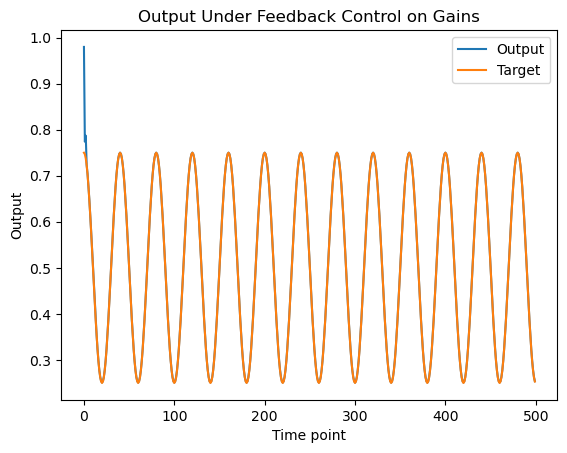

In [37]:
# fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(time_points[0:500], outputs_fb[0:500], label='Output')
plt.plot(time_points[0:500],targets[0:500], label='Target')
plt.title('Output Under Feedback Control on Gains')
plt.xlabel('Time point')
plt.ylabel('Output')
plt.legend()
if SAVEFIG:
    plt.savefig("fig/FORCE_basis_tracking_output_0510.png")

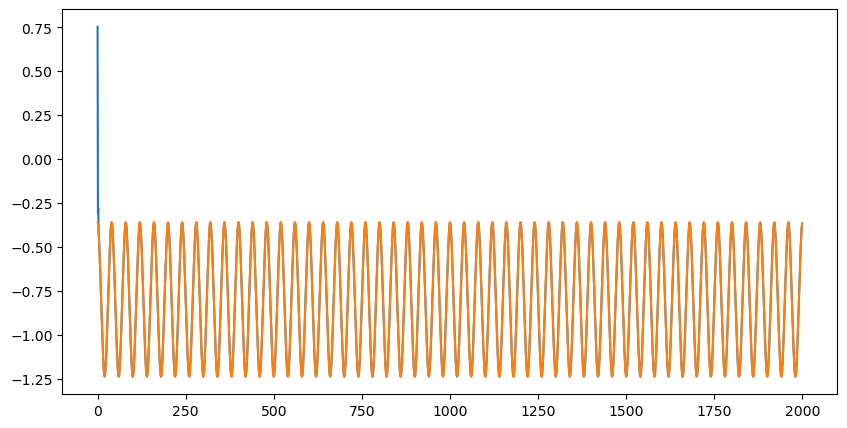

In [16]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(outputs_fb_beforesig)
plt.plot(y_tildes)

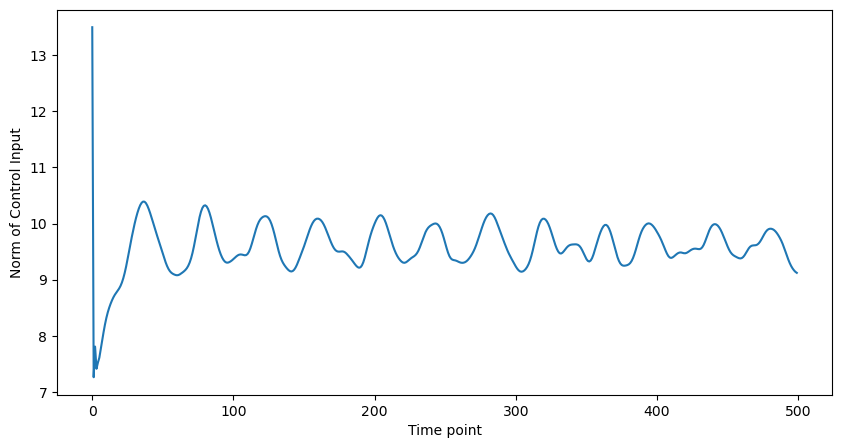

In [17]:
fig, ax = plt.subplots(figsize=(10, 5))
us_norm = [np.linalg.norm(u) for u in us_fb]

plt.plot(us_norm[0:500])
plt.ylabel('Norm of Control Input')
plt.xlabel('Time point')
if SAVEFIG:
    plt.savefig("fig/FORCE_tracking_unorm_0424.png")

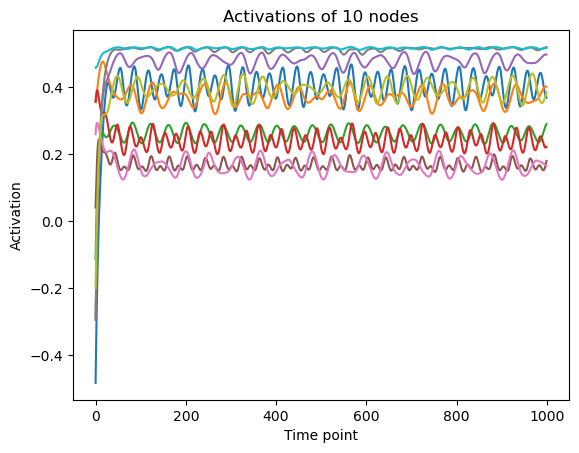

In [38]:
all_xs_fb = np.concatenate(xs_fb, axis=1)
# fig, ax = plt.subplots(figsize=(10, 5))
for i in range(20, 30):
    plt.plot(all_xs_fb[i,0:1000], label=f"Node {i}")
plt.xlabel("Time point")
plt.ylabel("Activation")
plt.title("Activations of 10 nodes")
if SAVEFIG:
    plt.savefig("fig/FORCE_basis_tracking_activations_0510.png")

### Discrete Tracking Control Plus Hebbian Learning

In [19]:
# calculate the desired output before the output sigmoid
gainout= 2.5 # 1.15
shiftout= -2 # -2.5
out_lr = 0.002
y_tildes = inv_sigmoid_np(targets) / gainout  + shiftout

In [20]:
# Simulate with control
x = init_state.copy()
u = init_state.copy() * 0
this_output_weight_matrix = output_weight_matrix.copy()
xs_hebb, us_hebb, outputs_hebb_beforesig, outputs_hebb = [x], [], [], []
has_hebbian = False
adjust_out = False

# constants
R = np.eye(num_nodes) * 0.0001
Q1 = np.eye(num_nodes) * 0.01
Q2 = np.eye(1) * 10
hebbian_lr = 0.01
u_scale = 1

for t in time_points[:-1]:

    # jnn.i = t

    # output
    output_beforesig = this_output_weight_matrix @ x
    output = sigmoid_np(gainout * (output_beforesig - shiftout))

    # update readout weights by hebbian learning
    if not has_hebbian and 1000 < t < 2000:
        has_hebbian = True
        x_mean = np.concatenate(xs_hebb, axis=1).mean(axis=1).reshape(-1, 1)
        x_std = np.concatenate(xs_hebb, axis=1).std(axis=1).reshape(-1, 1)
        # output_mean = np.array(outputs_fb).mean()
        output_mean = 0.5
        # target_mean = 0.5
    
    # # start adjusting the output gains and shifts
    # if t > 2000:
    #     adjust_out = True
    #     has_hebbian = False
    #     period = 2 * half_period
    
    if has_hebbian:
        # this_target = targets[t]
        # Calculate Hebbian weight updates
        # hebbian_update = (this_target - target_mean) * ((x - x_mean) / x_std).T
        hebbian_update = (output - output_mean) * ((x - x_mean) / x_std).T
        # hebbian_update = output * x.T
        # hebbian_update = hebbian_update * node_type
        # Normalized Hebbian learning
        tmp_output_weight_matrix = this_output_weight_matrix + hebbian_lr * hebbian_update
        tmp_ext = tmp_output_weight_matrix[:,node_type == 1]
        tmp_inh = tmp_output_weight_matrix[:,node_type == -1]
        tmp_ext[tmp_ext < 0] = 0
        tmp_inh[tmp_inh > 0] = 0
        tmp_ext /= np.sum(np.abs(tmp_ext)) / ext_weight_sum
        tmp_inh /= np.sum(np.abs(tmp_inh)) / inh_weight_sum
        tmp_output_weight_matrix[:,node_type == 1] = tmp_ext
        tmp_output_weight_matrix[:,node_type == -1] = tmp_inh
        # update init weights
        this_output_weight_matrix = tmp_output_weight_matrix.copy()
    
    # # adjust the gainout and shiftout
    # if adjust_out:
    #     mean_output = np.mean(outputs_hebb[t-period:t])
    #     amplitude = np.max(outputs_hebb[t-period:t]) - np.min(outputs_hebb[t-period:t])
    #     if np.abs(mean_output - 0.5) > 0.01:
    #         shiftout += out_lr * np.sign(mean_output - 0.5)
    #     if np.abs(amplitude - 0.5) > 0.01:
    #         gainout -= out_lr * np.sign(amplitude - 0.5)

    # input
    this_input = inputs[:,t]
    r = feedback_weight_matrix * this_input.reshape(-1,1)
    
    # linear approxmation of nonlinear system
    # linear approximate F and G
    F, G, _ = jnn.jacob(x, u, r)   # x_t, u_t-1
    c = jnn.f(x, u, r) - F @ x - G @ u  # the constant term after approximation
    # augment the system for the constant term
    F_aug = np.concatenate([np.concatenate([F, np.eye(num_nodes)], axis=1), np.concatenate([np.zeros((num_nodes, num_nodes)), np.eye(num_nodes)], axis=1)], axis=0)
    G_aug = np.concatenate([G, np.zeros((num_nodes, num_nodes))], axis=0)
    x_aug = np.concatenate([x, c], axis=0)

    # get H
    H = this_output_weight_matrix.T
    L = H @ np.linalg.inv(H.T @ H)
    H_bar = (np.eye(num_nodes) - L @ H.T).T
    Q = H_bar @ Q1 @ H_bar.T + H @ Q2 @ H.T
    y_tilde = y_tildes[t+1]
    x_tilde = L @ np.array([[y_tilde]])
    x_tilde_aug = np.concatenate([x_tilde, c], axis=0)
    # Q_aug = np.concatenate([np.concatenate([Q, np.zeros((num_nodes, num_nodes))], axis=1), np.concatenate([np.zeros((num_nodes, num_nodes)), np.eye(num_nodes)], axis=1)], axis=0)
    Q_aug = np.concatenate([np.concatenate([Q, np.zeros((num_nodes, num_nodes))], axis=1), np.concatenate([np.zeros((num_nodes, num_nodes)), np.zeros((num_nodes, num_nodes))], axis=1)], axis=0)

    # get the control input u
    # backward solve
    S_t2 = Q_aug
    b_t2 = np.zeros(shape=(2 * num_nodes, 1))
    S_t1 = F_aug.T @ (S_t2 - S_t2 @ G_aug @ np.linalg.inv(G_aug.T @ S_t2 @ G_aug + R) @ G_aug.T @ S_t2) @ F_aug + Q_aug
    K_T_t1 = -np.linalg.inv(G_aug.T @ S_t2 @ G_aug + R) @ G_aug.T @ S_t2 @ F_aug
    b_t1 = (F_aug.T + K_T_t1.T @ G_aug.T) @ b_t2 - Q_aug @ x_tilde_aug
    # calculate u_t
    u1 = -np.linalg.inv(G_aug.T @ S_t1 @ G_aug + R) @ G_aug.T @ (S_t1 @ F_aug @ x_aug + b_t1)
    # update u
    u = u1.copy()
    
    # if adjust_out:
    #     u_scale *= 0.99
    #     u = u_scale * u
    
    # update x
    x1 = jnn.f(x, u, r)
    # x1_0 = F @ x + G @ u + c
    # x1_1 = F_aug @ x_aug + G_aug @ u
    # print(np.linalg.norm(x1_0-x1))
    # print(np.linalg.norm(x1_1[0:num_nodes,:]-x1))
    x = x1.copy()
    
    # save
    xs_hebb.append(x)
    us_hebb.append(u)
    outputs_hebb_beforesig.append(output_beforesig.item())
    outputs_hebb.append(output.item())

# final readout for x_T
output_beforesig = this_output_weight_matrix @ x
output = sigmoid_np(gainout * (output_beforesig - shiftout))
outputs_hebb_beforesig.append(output_beforesig.item())
outputs_hebb.append(output.item())

In [21]:
gainout, shiftout

(2.5, -2)

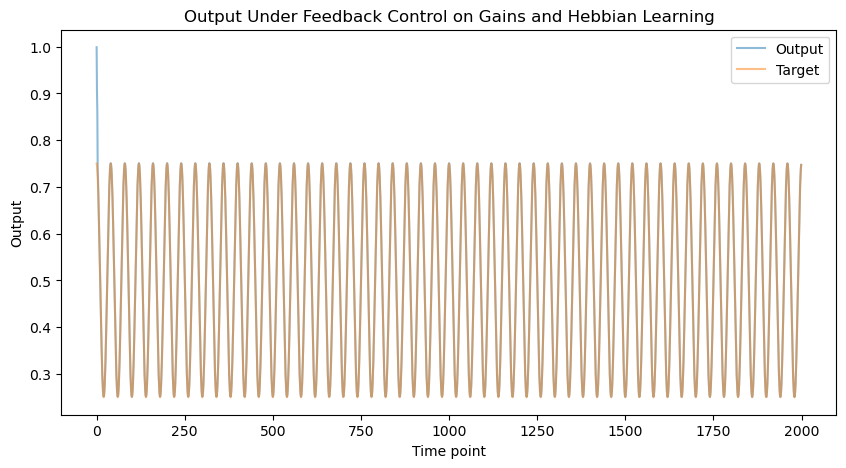

In [22]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(time_points, outputs_hebb, label='Output', alpha=0.5)
plt.plot(time_points, targets, label='Target', alpha=0.5)
plt.title('Output Under Feedback Control on Gains and Hebbian Learning')
plt.xlabel('Time point')
plt.ylabel('Output')
plt.legend()
if SAVEFIG:
    plt.savefig("fig/FORCE_hebb_output_0424.png")

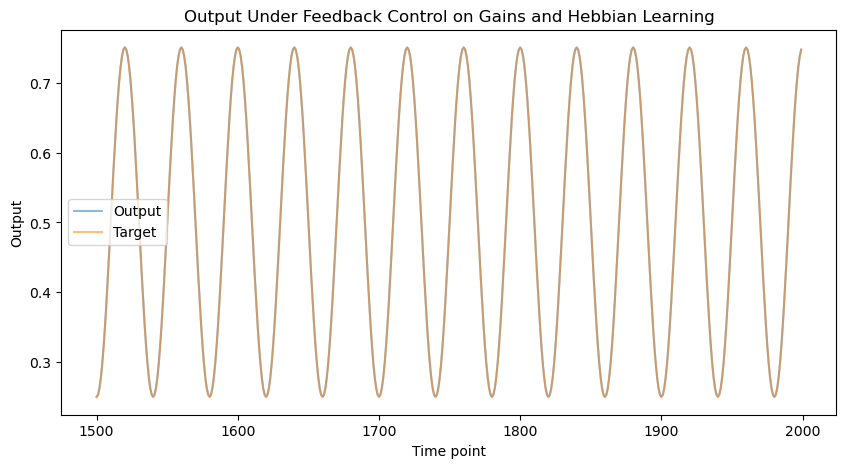

In [23]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(time_points[-500:], outputs_hebb[-500:], label='Output', alpha=0.5)
plt.plot(time_points[-500:], targets[-500:], label='Target', alpha=0.5)
plt.title('Output Under Feedback Control on Gains and Hebbian Learning')
plt.xlabel('Time point')
plt.ylabel('Output')
plt.legend()
if SAVEFIG:
    plt.savefig("fig/FORCE_hebb_output_0424.png")

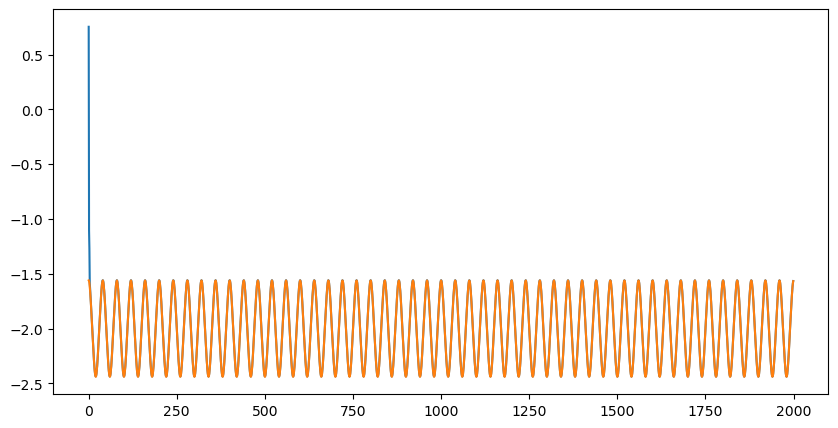

In [24]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(outputs_hebb_beforesig)
plt.plot(y_tildes)

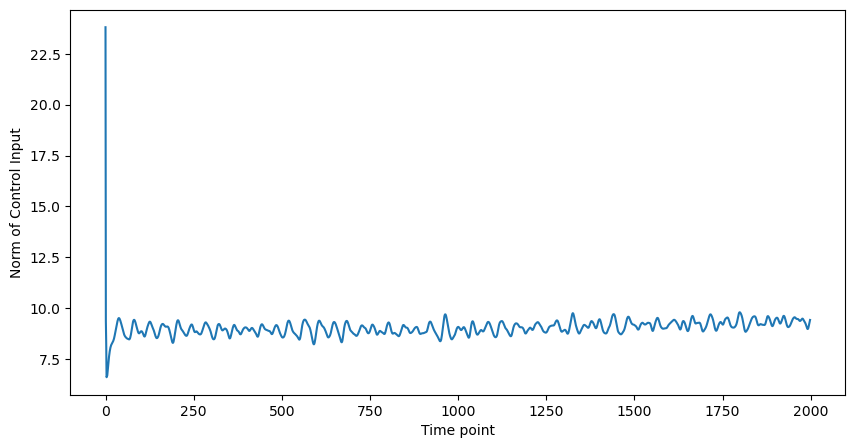

In [25]:
fig, ax = plt.subplots(figsize=(10, 5))
us_norm = [np.linalg.norm(u) for u in us_hebb]

plt.plot(us_norm)
plt.ylabel('Norm of Control Input')
plt.xlabel('Time point')
if SAVEFIG:
    plt.savefig("fig/FORCE_hebb_unorm_0424.png")

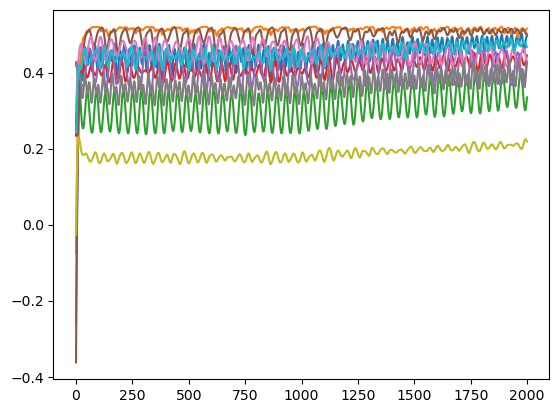

In [26]:
all_xs_hebb = np.concatenate(xs_hebb, axis=1)
for i in range(10, 20):
    plt.plot(all_xs_hebb[i,:], label=f"Node {i}")

In [27]:
peaks = []
start = 1500
end = start + 2*half_period
for i in range(num_nodes):
    y = all_xs_hebb[i]
    p = np.argmax(y[start:end])
    peaks.append(p)
target_peak = np.argmax(targets[start:end])
relative_peaks_hebb = np.array(peaks) - target_peak

# plus 120 for relative peaks less than 0
relative_peaks_hebb[relative_peaks_hebb < 0] += 2*half_period
relative_peaks_hebb

array([36, 36, 38, 20,  8, 23, 28, 35, 14, 12, 35,  8, 11,  6, 28,  1, 24,
        0,  7, 15,  5,  6,  1, 11, 35,  3, 19, 20,  2,  0,  8, 19, 16,  6,
       18,  3,  1, 26, 31,  2,  8,  4, 10, 30, 10,  4, 38,  0, 19,  0,  5,
       19, 18,  0,  2,  4,  6, 38,  3, 10, 37,  6,  6, 10, 16, 10, 14,  0,
        9, 20,  5,  4, 13,  1, 31, 15, 37,  5, 11, 17, 20, 33, 38,  0, 29,
        2,  2, 32,  6,  3, 34,  4,  0,  2, 39, 37, 19, 17, 28, 33, 19, 20,
        4, 28,  2, 10, 20, 17, 19, 19,  2,  7,  3,  2, 16,  2, 39, 39, 33,
        2, 10, 10, 29, 13,  0,  4, 18,  7, 33,  3,  7, 17, 38, 21, 10,  0,
       21,  4, 28, 17, 11,  4, 11,  5, 13,  8, 19, 31, 12, 18, 37,  7,  5,
       38, 19, 20,  1, 17, 13, 10,  3, 19,  5,  1, 31, 20, 13, 29,  1,  7,
       20, 30,  6, 22, 14, 22,  0, 21,  5, 20,  1, 19, 25,  9, 20, 30, 32,
       11,  7,  4, 17, 17, 13,  3,  7, 25, 34,  5, 38, 39])

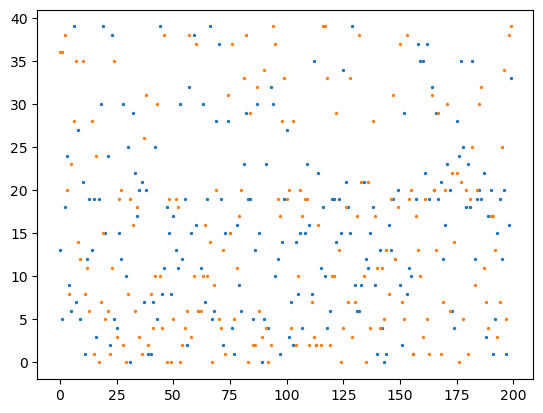

In [28]:
plt.scatter(np.arange(num_nodes), relative_peaks_ff_init, s=2)
plt.scatter(np.arange(num_nodes), relative_peaks_hebb, s=2)

In [29]:
# this_output_weight_matrix = this_output_weight_matrix / x_mean.T / 100

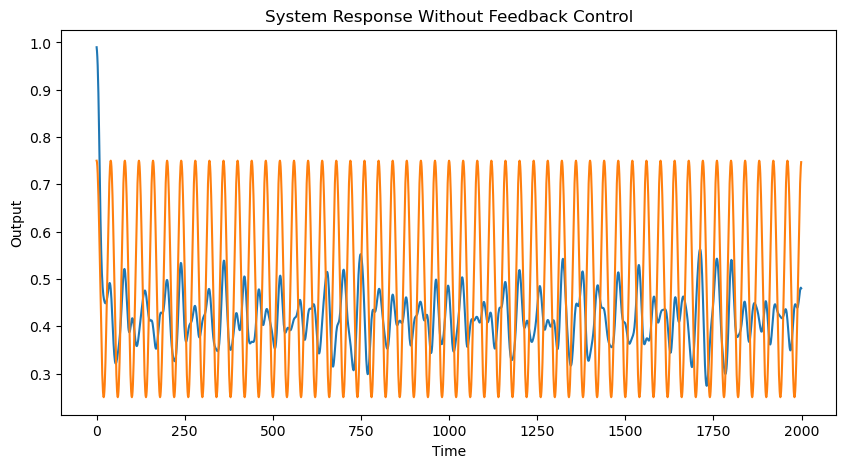

In [30]:
# Simulation Without Control
x = sigmoid_np(init_gain * (init_state.copy() - init_shift))
u = init_state.copy() * 0
xs_ff_after, outputs_ff_after = [x], []
gainout = 1.5 # 1
shiftout = -3 # -1.6

for i in time_points[:-1]:

    # output
    output_beforesig = this_output_weight_matrix @ x
    output = sigmoid_np(gainout * (output_beforesig - shiftout))

    # input
    this_input = inputs[:,i]
    r = feedback_weight_matrix * this_input.reshape(-1, 1)
    
    # update x
    x1 = jnn_ff.f(x, u, r)
    x = x1.copy()

    # save
    xs_ff_after.append(x)
    outputs_ff_after.append(output.item())

# final readout for x_T
output_beforesig = this_output_weight_matrix @ x
output = sigmoid_np(gainout * (output_beforesig - shiftout))
outputs_ff_after.append(output.item())

# Plot the output
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(time_points, outputs_ff_after)
plt.plot(time_points, targets)
plt.xlabel('Time')
plt.ylabel('Output')
plt.title('System Response Without Feedback Control')
plt.show()

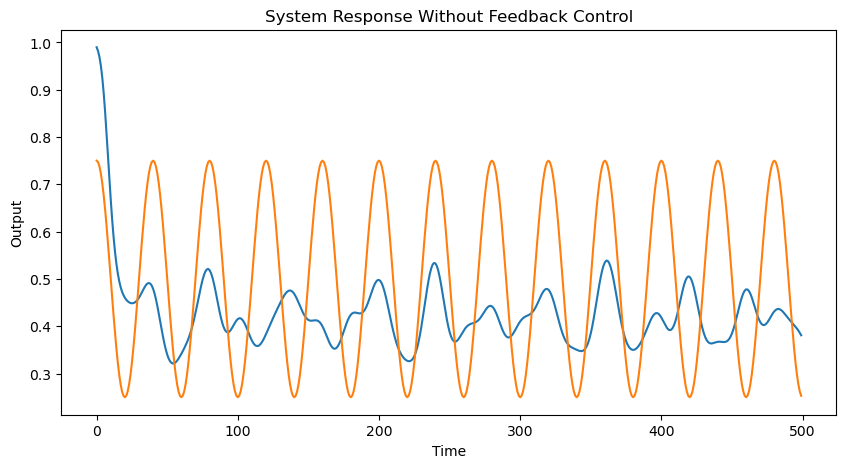

In [31]:
# Plot the output
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(time_points[0:500], outputs_ff_after[0:500])
plt.plot(time_points[0:500], targets[0:500])
plt.xlabel('Time')
plt.ylabel('Output')
plt.title('System Response Without Feedback Control')
if SAVEFIG:
    plt.savefig("fig/FORCE_ff_outputs_after_0424.png")

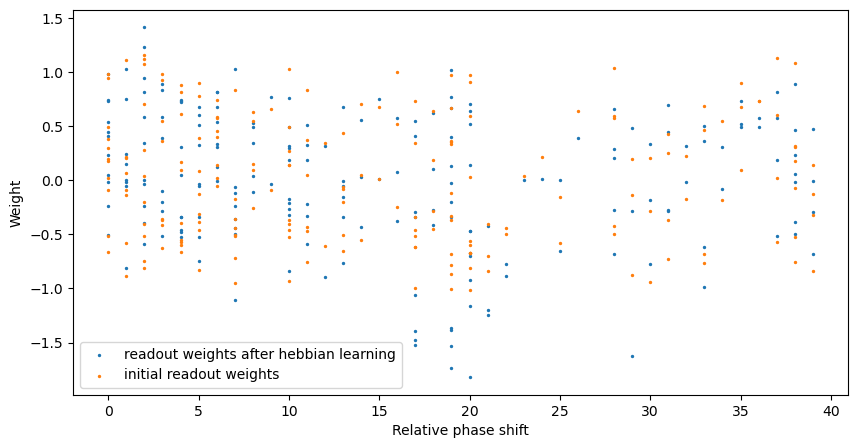

In [32]:
plt.subplots(figsize=(10, 5))
plt.scatter(relative_peaks_hebb, this_output_weight_matrix.flatten(), s=2, label="readout weights after hebbian learning")
plt.scatter(relative_peaks_hebb, output_weight_matrix.flatten(), s=2, label="initial readout weights")
plt.xlabel("Relative phase shift")
plt.ylabel("Weight")
plt.legend()

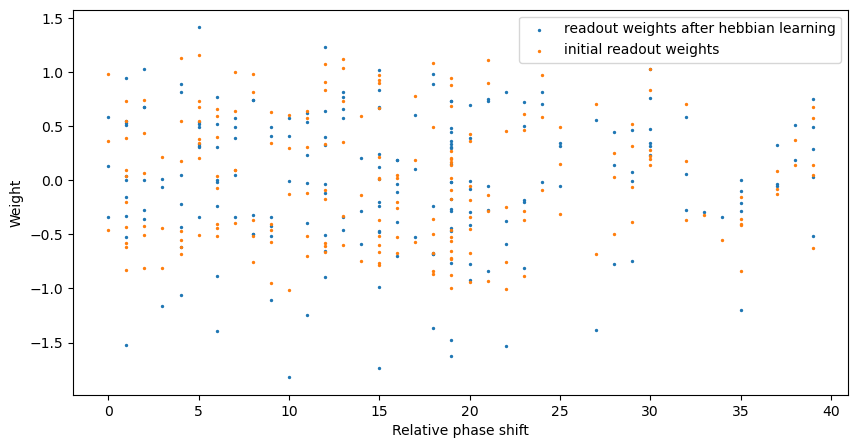

In [33]:
plt.subplots(figsize=(10, 5))
plt.scatter(relative_peaks_ff_init, this_output_weight_matrix.flatten(), s=2, label="readout weights after hebbian learning")
plt.scatter(relative_peaks_ff_init, output_weight_matrix.flatten(), s=2, label="initial readout weights")
plt.xlabel("Relative phase shift")
plt.ylabel("Weight")
plt.legend()
if SAVEFIG:
    plt.savefig("fig/FORCE_weight_phase_0424.png")